In [33]:
from data_preprocessing import Preprocessing
import seaborn as sns
from metrics import log_mse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRFRegressor

In [34]:
data_preprocess = Preprocessing('../data/train.csv')

In [35]:
data = data_preprocess.preprocess()

In [36]:
data_numeric = data_preprocess.preprocess(only_numeric=True)

In [37]:
target = 'SalePrice'

In [38]:
cM  = data_numeric.corr()

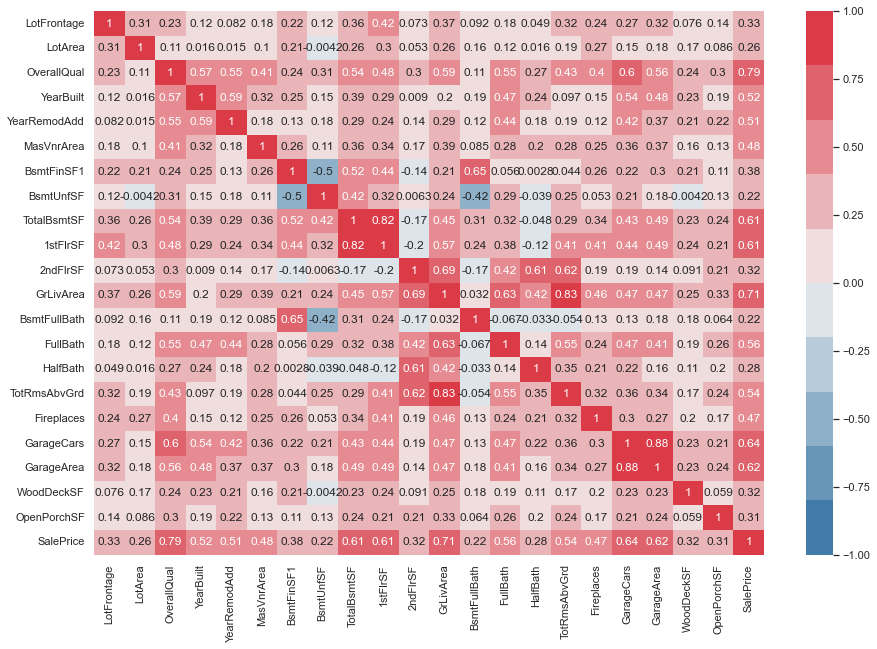

In [39]:
sns.set(rc={'figure.figsize': (15,10)})
color_map = sns.diverging_palette(240,10,n=10)
sns.heatmap(cM, vmin=-1., vmax=1., cmap=color_map, annot=True);

In [40]:
# Removing column because of too large correlation with others
data_numeric.drop('TotRmsAbvGrd', axis=1, inplace=True)

## Base model with only numeric columns using linear regression

In [41]:
x_train, x_test, y_train, y_test = train_test_split(data_numeric.drop(target, axis=1), data_numeric[target], random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1088, 20), (363, 20), (1088,), (363,))

In [42]:
std_scaler = StandardScaler()
x_train_std = std_scaler.fit_transform(x_train)
x_test_std = std_scaler.transform(x_test)

In [43]:
lin_reg = LinearRegression()
lin_reg.fit(x_train_std, y_train)
y_pred = lin_reg.predict(x_test_std)
y_pred = abs(y_pred)

In [44]:
log_mse(y_test, y_pred)

0.22243428704314985

## Models using data that includes preprocessed categorical columns

In [45]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(target, axis=1), data[target], random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape 

((1088, 233), (363, 233), (1088,), (363,))

In [46]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(x_train, y_train)
y_pred = forest_reg.predict(x_test)

log_mse(y_test, y_pred)

0.1403506442969382

In [47]:
log_mse_scorer = make_scorer(log_mse, greater_is_better=False)

In [48]:
params = {'n_estimators': [40, 50, 70],
         'max_depth': [8, 10, 12],
         'min_samples_split': [ 6, 8, 10]}

In [49]:
forest_grid = GridSearchCV(estimator=forest_reg, param_grid=params, cv=5, scoring= log_mse_scorer)                   
forest_grid.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid={'max_depth': [8, 10, 12],
                         'min_samples_split': [6, 8, 10],
                         'n_estimators': [40, 50, 70]},
             scoring=make_scorer(log_mse, greater_is_better=False))

In [50]:
abs(forest_grid.best_score_)

0.1530610705678222

In [51]:
forest_grid.best_params_

{'max_depth': 12, 'min_samples_split': 6, 'n_estimators': 50}

In [52]:
best_estimator = forest_grid.best_estimator_

In [53]:
best_estimator.fit(x_train, y_train)
y_pred = best_estimator.predict(x_test)
log_mse(y_test, y_pred)

0.14162410024889371

In [54]:
xgb_reg = XGBRFRegressor(random_state=42)
xgb_reg.fit(x_train, y_train)

XGBRFRegressor(base_score=0.5, booster='gbtree', callbacks=None,
               colsample_bylevel=1, colsample_bytree=1,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
               importance_type=None, interaction_constraints='', max_bin=256,
               max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
               min_child_weight=1, missing=nan, monotone_constraints='()',
               n_estimators=100, n_jobs=0, num_parallel_tree=100,
               objective='reg:squarederror', predictor='auto', random_state=42,
               reg_alpha=0, sampling_method='uniform', scale_pos_weight=1, ...)

In [55]:
y_pred = xgb_reg.predict(x_test)
log_mse(y_test, y_pred)

0.1557787714775515

In [56]:
params = {'n_estimators': [110, 120, 130],
         'max_depth': [10,15],
         'eta': [0.2]}

In [57]:
xgb_grid = GridSearchCV(estimator=xgb_reg, param_grid=params, cv=5, scoring= log_mse_scorer)                   
xgb_grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRFRegressor(base_score=0.5, booster='gbtree',
                                      callbacks=None, colsample_bylevel=1,
                                      colsample_bytree=1,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=0, gpu_id=-1,
                                      grow_policy='depthwise',
                                      importance_type=None,
                                      interaction_constraints='', max_bin=256,
                                      max_cat_to_onehot=4, max_delta_step=0,
                                      max_depth=6, m...
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints='()',
                                      n_estimators=100, n_jobs=0,
                                 

In [58]:
abs(xgb_grid.best_score_)

0.15495346758884623

In [59]:
xgb_grid.best_params_

{'eta': 0.2, 'max_depth': 15, 'n_estimators': 110}

In [60]:
best_xgb = xgb_grid.best_estimator_

In [61]:
best_xgb.fit(x_train, y_train)
y_pred = best_xgb.predict(x_test)
log_mse(y_test, y_pred)

0.13733510979350297